<a href="https://colab.research.google.com/github/normanli33/algorithms-sedgewick-python/blob/master/week2c_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

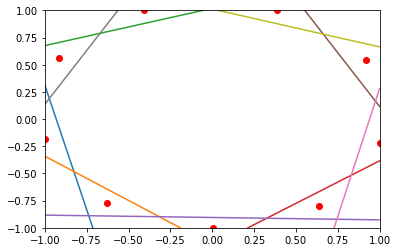

In [ ]:
# encoder_main.py
# COMP9444, CSE, UNSW

from __future__ import print_function
import torch
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
#import numpy as np


class EncModel(torch.nn.Module):
    # fully connected two-layer network
    def __init__(self, num_input, num_hid, num_out):
        super(EncModel, self).__init__()
        self.in_hid  = torch.nn.Linear(num_input, num_hid)
        self.hid_out = torch.nn.Linear(num_hid, num_out)
    def forward(self, input):
        hid_sum = self.in_hid(input)
        hidden  = torch.tanh(hid_sum)
        out_sum = self.hid_out(hidden)
        output  = torch.sigmoid(out_sum)
        return(output)

def plot_hidden(net):
    # plot the hidden unit dynamics of the network
    plt.xlim(-1,1), plt.ylim(-1,1) # limits of x and y axes

    # input to hidden weights and biases
    weight = net.in_hid.weight.data.cpu()
    bias   = net.in_hid.bias.data.cpu()

    num_in  = net.in_hid.weight.data.size()[1]
    num_out = net.hid_out.weight.data.size()[0]

    # draw a dot to show where each input is mapped to in hidden unit space
    P = torch.tanh(weight + bias.unsqueeze(1).repeat(1,num_in))
    plt.plot(P[0,:],P[1,:],'ro')

    # draw a line interval to show the decision boundary of each output
    for i in range(num_out):

        A = net.hid_out.weight.data.cpu()[i,0]
        B = net.hid_out.weight.data.cpu()[i,1]
        C = net.hid_out.bias.data.cpu()[i]

        j = 0;
        if A == 0:
            if B != 0:
                y0 = -C/B
                if -1 < y0 and y0 < 1:
                    j = 2
                    plt.plot([-1,1],[y0,y0])
        elif B == 0:
            if A != 0:
                x0 = -C/A
                if -1 < x0 and x0 < 1:
                    plt.plot([x0,x0],[-1,1])
        else:
            x = torch.zeros(2)
            y = torch.zeros(2)
            y0 = (A-C)/B
            if -1 <= y0 and y0 <= 1:
                x[j] = -1
                y[j] =  y0
                j = j+1
            y0 = (-A-C)/B
            if -1 <= y0 and y0 <= 1:
                x[j] =  1
                y[j] =  y0
                j = j+1
            x0 = (B-C)/A
            if j < 2 and -1 <= x0 and x0 <= 1:
                x[j] =  x0
                y[j] = -1
                j = j+1
            x0 = (-B-C)/A
            if j < 2 and -1 <= x0 and x0 <= 1:
                x[j] =  x0
                y[j] =  1
                j = j+1
            if j > 1:
                plt.plot(x,y)

def main():
    target = torch.eye(9)

    num_in  = target.size()[0]
    num_out = target.size()[1]

    # input is one-hot with same number of rows as target
    input  = torch.eye(num_in)
    target = torch.eye(num_in)

    xor_dataset  = torch.utils.data.TensorDataset(input,target)
    train_loader = torch.utils.data.DataLoader(xor_dataset,batch_size=num_in)

    # create neural network according to model specification
    net = EncModel(num_in,2,num_out)

    # initialize weights, but set biases to zero
    net.in_hid.weight.data.normal_(0,0.001)
    net.hid_out.weight.data.normal_(0,0.001)
    net.in_hid.bias.data.zero_()
    net.hid_out.bias.data.zero_()

    # SGD optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=0.4,momentum=0.9)

    loss = 1.0
    epoch = 0

    while epoch < 100000 and loss > 0.02:
        epoch = epoch+1
        for batch_id, (data,target) in enumerate(train_loader):
            #data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # zero the gradients
            output = net(data)    # apply network
            loss = F.binary_cross_entropy(output,target)
            loss.backward()       # compute gradients
            optimizer.step()      # update weights
            if epoch % 100 == 0:
                # print('ep%3d: loss = %7.4f' % (epoch, loss.item()))
                continue

    plot_hidden(net)
    plt.savefig("encoder.png")

if __name__ == '__main__':
    main()
